<a href="https://colab.research.google.com/github/weamalkhaldi/weam-M.L/blob/main/weam_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
files are being loaded...
loaded successfully


/tmp/ipython-input-2497191756.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index,y=missing_data.values,palette = 'viridis')


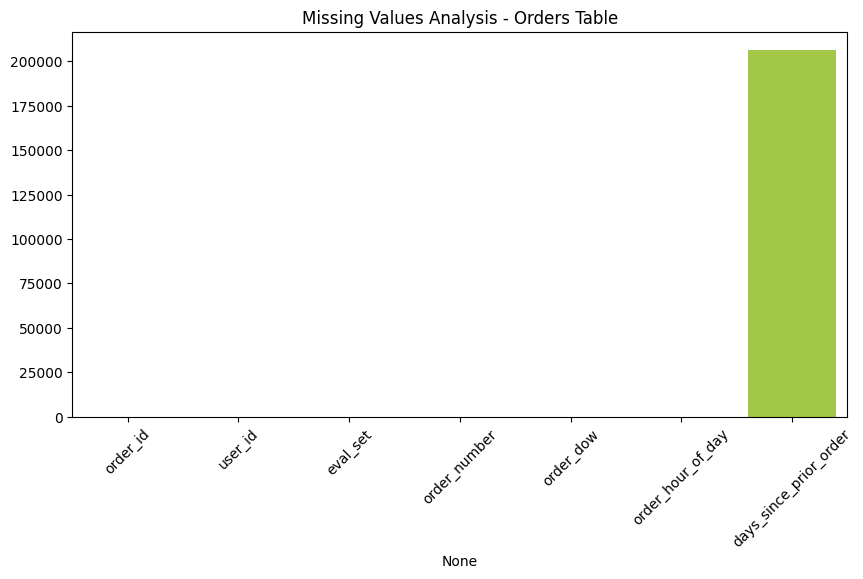

the code has run ... the plot is now displayed


In [ ]:
# Importing some libraries (data ingestion)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#تفعيل الوصول لملفات قوقل درايف
from google.colab import drive
drive.mount('/content/drive')

#تحديد المسار للملف
path = '/content/drive/MyDrive/Instacart_Project_MMMMLLLLL/'
#تقليل الذاكرة بدنا نعمل memory savvy عشان نصغر حجمالبيانات
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
             df[col] = pd.to_numeric(df[col],
downcast='integer')
        elif df[col].dtype == 'float64':
                                         df[col] = pd.to_numeric(df[col],
downcast = 'float')
    return df
#تحميل الملفات
print("files are being loaded...")
orders = reduce_mem_usage(pd.read_csv(path + 'orders.csv'))
products = reduce_mem_usage(pd.read_csv(path + 'products.csv'))
aisles = reduce_mem_usage(pd.read_csv(path + 'aisles.csv'))
departments = reduce_mem_usage(pd.read_csv(path + "departments.csv"))
print("loaded successfully")
#تحليل القيم المفقودة و رسمها EDA
missing_data = orders.isnull().sum()

plt.figure(figsize=(10 , 5))
sns.barplot(x=missing_data.index,y=missing_data.values,palette = 'viridis')
plt.title('Missing Values Analysis - Orders Table')
plt.xticks(rotation=45)
plt.savefig('missing_values_plot.png')
plt.show()
print("the code has run ... the plot is now displayed")
#هون خلصت اول اشي انطلب و هو EDA --> EDA
#الان نبدا ب heavy preprocessing :
# join :
products_full = pd.merge(products,
aisles , on='aisle_id', how='left')
products_full = pd.merge(products_full, departments , on='department_id' , how='left' )

In [ ]:
# 3 هسه بدي اعمل تحليل للقيم المفقودة ,لاحظنا انه طلع معنا اكثر من 200 الف قيمة مفقودة عشان هيك يلا نبدأ define and justify imputatiom
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0) #--> هون عوضت القيم المفقودة في عمود الايام منذ الطلب السابق ب 0
print(orders.isnull().sum())#--> عشان اتأكد هل القيم المفقودة اختفت ؟؟

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64


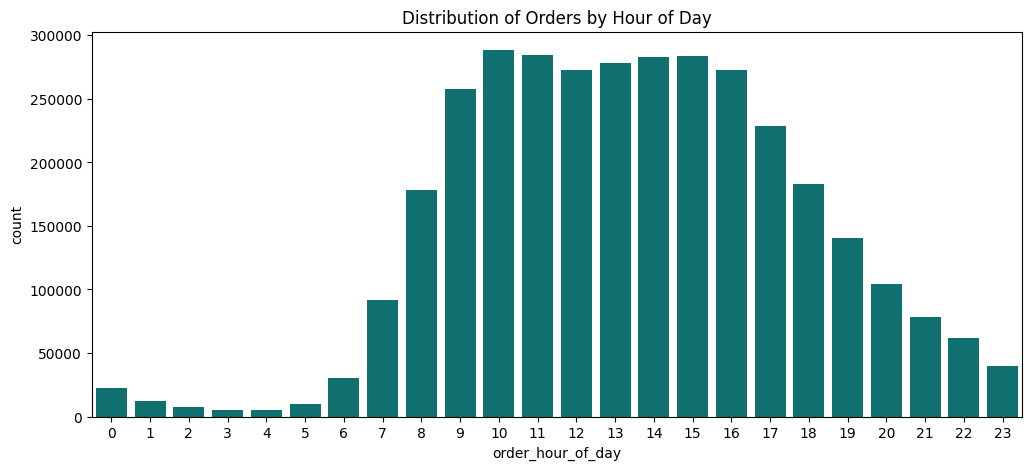

In [ ]:
#3هسه بدنا نوزع الطلبات حسب ساعة اليوم
plt.figure(figsize=(12,5))
sns.countplot(data=orders,x='order_hour_of_day' , color='teal')
plt.title('Distribution of Orders by Hour of Day')
plt.show()

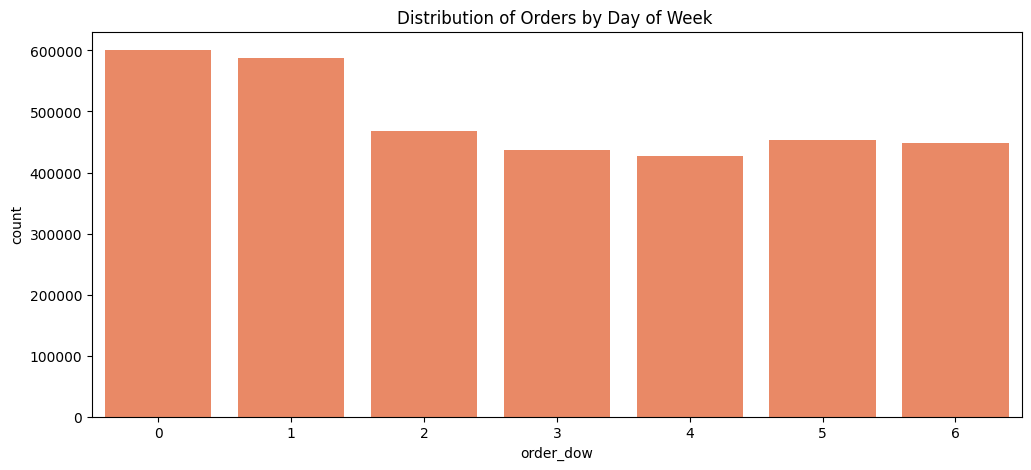

In [ ]:
#3هسه نوزع الطلبات حسب يوم الاسبوع
plt.figure(figsize=(12,5))
sns.countplot(data=orders,x='order_dow' , color='coral')
plt.title('Distribution of Orders by Day of Week ')
plt.show()

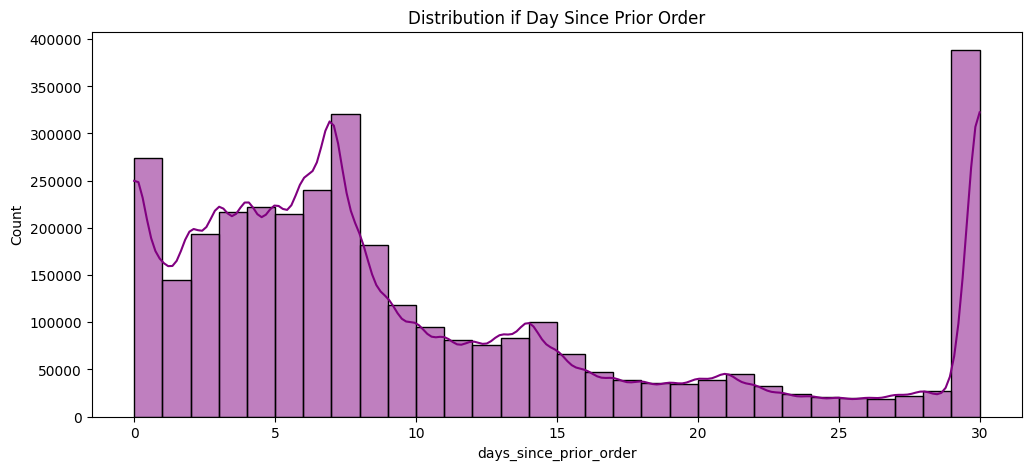

In [ ]:
#3هسه بدنا نعمل تحليل لعد الايام , بما انه اكتشفنا قيم مفقود لازم نرسم التوزيع عشان نعالج
plt.figure(figsize=(12,5))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=True , color= 'purple')
plt.title('Distribution if Day Since Prior Order')
plt.show()

In [ ]:
# Encoding Categorical Variabls
# نبدأ الان خطوة 4
#بهاي الخوة بدنا نجهز لغة الارقام للموديل و حسب ملف الفاينل بروجطت في ثلاث استراتيجيات لمختلفة لازم نعملهم للترميز
#الاستراتيجية الاولى : (One-Hot Encoding OHE) ----> هاي الطريقة مناسبة للفئات الي ما الهم خيارات كثير يعني هم (low-cardinality)--> نطبقها على ايام الاسبوع
#ليه ؟ عشان نحول ايام الاسبوع الى عمدة منفصلة
orders_ohe = pd.get_dummies(orders,columns=['order_dow'], prefix='day')
print(orders_ohe.head())

   order_id  user_id eval_set  order_number  order_hour_of_day  \
0   2539329        1    prior             1                  8   
1   2398795        1    prior             2                  7   
2    473747        1    prior             3                 12   
3   2254736        1    prior             4                  7   
4    431534        1    prior             5                 15   

   days_since_prior_order  day_0  day_1  day_2  day_3  day_4  day_5  day_6  
0                     0.0  False  False   True  False  False  False  False  
1                    15.0  False  False  False   True  False  False  False  
2                    21.0  False  False  False   True  False  False  False  
3                    29.0  False  False  False  False   True  False  False  
4                    28.0  False  False  False  False   True  False  False  


In [ ]:
#الاستراتيجية الثانية : (Frequency Encoding) --> هاي الطريقة للاعمدة الي تحتوي على خيارات كثيرة مثلا زي اسماء الاقسام ليه طيب مناسبة ؟ لانها تستبدل الاسم بنسبة تكراره قي البيانات
dept_freq = products_full['department'].value_counts(normalize= True)
products_full['dept_freq_enc'] = products_full['department'].map(dept_freq)
print(products_full[['department','dept_freq_enc']].head())

  department  dept_freq_enc
0     snacks       0.126067
1     pantry       0.108095
2  beverages       0.087848
3     frozen       0.080643
4     pantry       0.108095


In [ ]:
#الاستراتيجية الثالثة : Target/Mean Encoding ----->  هاي الطريقة حلوة لانه نحول الصنف الى رقم بناءا على متوسط الهدف مثلا كم مرة تم اعادة شراء هذا المنتج بالمتوسط ولكننننن عشان رح يصير عندنا تسريب للبيانات (leakage) -> يفضل استخدامها لاحقا لما نربط بيانات التدريب بالهدف
#توضيح بسيط :عشان نتفادى تسريب البيانات نقدر نعمل (k-fold) & (smoothing) --> و لكن رح نعملهم بعد خطوة 6 عشان احنا بنحتاج target يكون مربوط مع ال features

In [ ]:
from pandas.io import clipboards
# خطوة 5
from sklearn.preprocessing import StandardScaler
#تعريف scaler
scaler = StandardScaler()
#تحديد الاعمدة الرقمية الي بدنا نعمل الها scaling
'order_number' , 'order_dow' , 'order_hour_of_day','days_since_prior_order'
cols_to_scale = ['order_number','order_dow','order_hour_of_day','days_since_prior_order']
#تطبيق ال scaling
orders[cols_to_scale] = scaler.fit_transform(orders[cols_to_scale])
#نعرض النتيجة عشان نشوف انو الارقام صارت متقاربةو صغنونة ؟؟
print(orders[cols_to_scale].head())



   order_number  order_dow  order_hour_of_day  days_since_prior_order
0     -0.910997  -0.379230          -1.290086               -1.122053
1     -0.854605   0.109331          -1.526711                0.489339
2     -0.798214   0.109331          -0.343584                1.133896
3     -0.741822   0.597891          -1.526711                1.993304
4     -0.685431   0.597891           0.366293                1.885878


In [ ]:
#6
path = '/content/drive/MyDrive/Instacart_Project_MMMMLLLLL/'
orders = pd.read_csv(path + 'orders.csv')
prior = pd.read_csv(path + 'order_products__prior.csv')
user_features = orders.groupby('user_id').agg(total_orders=('order_number','max'),mean_days_between=('days_since_prior_order','mean')).reset_index()
merged_prior = pd.merge(prior,orders,on = 'order_id',how = 'left')
user_reorder_ratio = merged_prior.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_ratio.columns = ['user_id' ,'user_reorder_ratio']
user_features = pd.merge(user_features , user_reorder_ratio , on = 'user_id', how = 'left')
print("done user features ")
user_features.head()

done user features 


,user_id,total_orders,mean_days_between,user_reorder_ratio
0,1,11,19.000000,0.694915
1,2,15,16.285714,0.476923
2,3,13,12.000000,0.625000
3,4,6,17.000000,0.055556
4,5,5,11.500000,0.378378


doneee
Index(['user_id', 'total_orders', 'mean_days_between', 'user_reorder_ratio'], dtype='object')


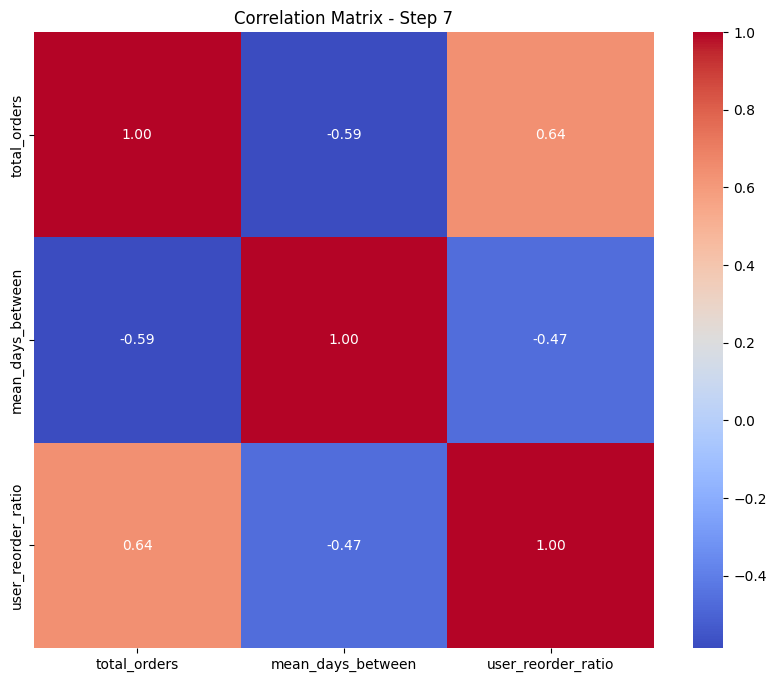

yse 


In [ ]:
#7 بهاي الخطوة بدنا نشوف هل ال (features) الي عملناها هل هي متكررة او لا
user_features = orders.groupby('user_id').agg(total_orders=('order_number','max'),mean_days_between=('days_since_prior_order','mean')).reset_index()
user_reorder_ratio = merged_prior.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_ratio.columns = ['user_id', 'user_reorder_ratio']
final_df = pd.merge(user_features, user_reorder_ratio, on='user_id', how='left')
print("doneee")
print(final_df.columns)
import seaborn as sns
import matplotlib.pyplot as plt
cols_to_corr = ['total_orders', 'mean_days_between', 'user_reorder_ratio']
corr_matrix = final_df[cols_to_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Step 7')
plt.show()
print("yse ")



#نحسب مصفوفة الارتباط للميزات التي عملناها بخطوة 6
##corr_matrix = final_df[['total_orders','avg_days_between_orders' , 'overall_reorder_rate','avg_pos_in_cart','uxp_total_bought']].corr()
#نرسم خريطة حرارية عشان نشوف العلاقات كيف
##plt.figure(figsize=(10,8))
####sns.heatmap(corr_matrix,annot= True,cmap='coolwarm',fmt=".2f")
####plt.title('Correlation Matrix - step 7')
##plt.show()


thlel
user_reorder_ratio
1    83.697123
0    16.302877
Name: proportion, dtype: float64


/tmp/ipython-input-340650465.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=temp_target, palette='viridis')


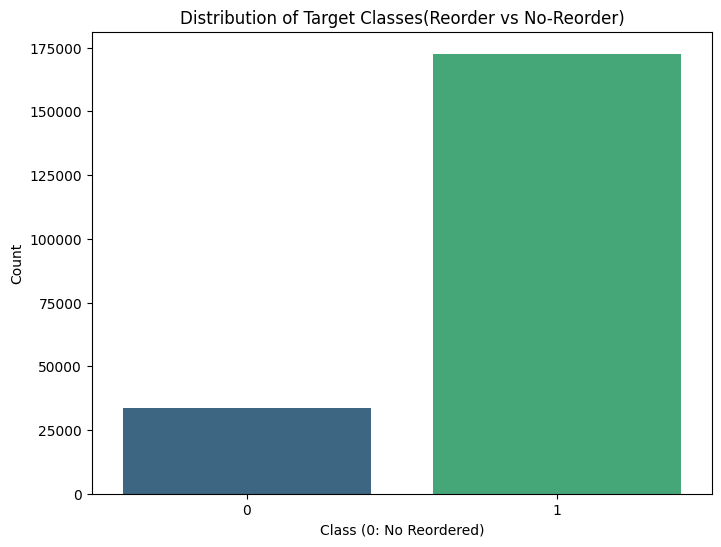

Note : SMOT and class weight will be applied during the model phase(step10-13)to compare results  


In [ ]:
#8
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE #--> مكتبة التعامل مع عد التوازن
if 'user_reorder_ratio' in final_df.columns:
  temp_target = final_df['user_reorder_ratio'].apply(lambda x: 1 if x > 0.2 else 0)
  print("thlel")
  print(temp_target.value_counts(normalize=True) * 100)
  plt.figure(figsize=(8, 6))
  sns.countplot(x=temp_target, palette='viridis')
  plt.title('Distribution of Target Classes(Reorder vs No-Reorder)')
  plt.xlabel('Class (0: No Reordered)')
  plt.ylabel('Count')
  plt.show()
  print("Note : SMOT and class weight will be applied during the model phase(step10-13)to compare results  ")



In [ ]:
from matplotlib import axis
from typing_extensions import final
#9
final_df = final_df.sort_values(['user_id' , 'total_orders'])
train_data = final_df[final_df['total_orders'] < final_df['total_orders'].max()]
test_data = final_df[final_df['total_orders'] == final_df['total_orders'].max()]
X_train = train_data.drop(['user_id'], axis=1)
y_train = train_data['user_reorder_ratio'].apply(lambda x: 1 if x>0.2 else 0)
X_test = test_data.drop(['user_id'], axis=1)
y_test = test_data['user_reorder_ratio'].apply(lambda x: 1 if x > 0.2 else 0)
print(f"Train set size: {X_train.shape}")
print(f"Test set size : {X_test.shape}")
print("the data was split based on chronological order to ensure no data leakage")



Train set size: (204835, 3)
Test set size : (1374, 3)
the data was split based on chronological order to ensure no data leakage


In [ ]:
#سوف نبدأ بحل task A
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix


#الان سوف ننشىء بيانات تجريبية (غير متوازية),هاض يحاكي الواقع لما تكون فئة(معينة )نادرة
x, y =make_classification(n_samples=1000,n_features=10, weights=[0.9, 0.1],random_state=42)

#تقسيم البيانات (تدريب و اختبار)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42)

#تحجيم البيانات(scaling)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#بناء نموذج
model = LogisticRegression(
    penalty='l2',
    class_weight='balanced',
    solver='liblinear',
    C=1.0,
    random_state=42
    )
    #تدريب النموذج
model.fit(x_train_scaled, y_train)

     # التنبؤ واستخراج النتائج
y_pred = model.predict(x_test_scaled)
     #طباعة التقارير النهائية
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Confusion Matrix ---
[[190  29]
 [  5  26]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       219
           1       0.47      0.84      0.60        31

    accuracy                           0.86       250
   macro avg       0.72      0.85      0.76       250
weighted avg       0.91      0.86      0.88       250



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import load_iris
#تحميل البيانات (هون استخدمنا مجموعة بيانات Irisالشهيرة كمثال)
data = load_iris()
x = data.data #هون اعتبرنا انها الميزات
y = data.target #وهون اعتبرنا انها التصنيفات

#هسه بدنا نقسم البيانات (قسمناها 80% تدريب , و20% اختبار)
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2,random_state=42)

#تطبيع البيانات(Scaling)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#بناء النموذج وتحدي عدد الجيران
#(K=5)
knn = KNeighborsClassifier(n_neighbors=5)

#تدريب النموذج
knn.fit(x_train, y_train)

#التنبؤ بالنتائج
y_pred = knn.predict(x_test)

#تقييم النتائج
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy Score: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
#بناء نموذج SVM
#kernel='rbf' يعالج البيانات المعقدة
#هسه اذا بدنا اياه خطي نقدر نغير rbfالى linear
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
#تدريب النموذج
svm_model.fit(x_train, y_train)
#التنبؤ بالنتائج
y_pred_svm = svm_model.predict(x_test)

#عرض النتائج
print("--- نتائج النموذج SVM ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_svm))

--- نتائج النموذج SVM ---
Accuracy Score: 100.00%

Detailed Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
#بناء النموذج
#max_depth=3 نحدد العمق عشان نضمن عدم منع تعقيد الشجرة اكثر من اللازم(Overfitting)
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
#تدريب النموذج
dt_model.fit(x_train, y_train)
#التنبؤ بالنتائج
y_pred_dt = dt_model.predict(x_test)
#التقييم
print("---نتائج Decision Tree ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
print(classification_report(y_test, y_pred_dt))

---نتائج Decision Tree ---
Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
#بناء النموذج
# n_estimators=100 تعني انشاء غابة من (100) شجرة
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#تدريب النموذج
rf_model.fit(x_train, y_train)

#التنبؤ بالنتائج
y_pred_rf = rf_model.predict(x_test)
#التقييم
print("---نتائج Random Forest ---")
print(f"accuracy:{accuracy_score(y_test, y_pred_rf) * 100:.2f}%")
print(classification_report(y_test, y_pred_rf))

---نتائج Random Forest ---
accuracy:100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
#بناء النموذج
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,random_stste=42)
#تدريب النموذج
xgb_model.fit(x_train, y_train)
#التنبؤ بالنتائج
y_pred_xgb = xgb_model.predict(x_test)
#عرض النتائج
print("--- نتائج XGBoost ---")
print(f"Accuracy:{accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")
print(classification_report(y_test, y_pred_xgb))


--- نتائج XGBoost ---
Accuracy:100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:52:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "random_stste" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.metrics import classification_report
#تعريف الموديلات الاساسية
base_model = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),('dt',
    DecisionTreeClassifier(max_depth=5)),('log_reg', LogisticRegression())
]

#تعريف الموديل النهائي
meta_model = LogisticRegression()
#بناء ال stacking Classifier
stacking_model = StackingClassifier(estimators=base_model, final_estimator=meta_model
                                    )
#تدريب الموديل
stacking_model.fit(x_train, y_train)
#التنبؤ وعرض النتائج
y_pred_stacking = stacking_model.predict(x_test)
print("--- نتائج Stacking Classifier ---")
print(f"Accuracy:{accuracy_score(y_test, y_pred_stack) * 100:.2f}%")
print(classification_report(y_test, y_pred_stack))


NameError: name 'x_train' is not defined